###  steps to process data and model, train. validate & predict


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.utils import plot_model


In [2]:
dataset_file = './data/movie_dataset.csv'

In [3]:
VOCAB_WORDLIMIT = 20000
SEQUENCE_LEN = 2000

BATCH_SIZE = 256
EPOCHS = 5
LEARNING_RATE = 1e-3


top_genre = ['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror']


In [4]:
def reload_dataset():
    df_dataset = pd.read_csv(dataset_file)
    print("total movies loaded:", len(df_dataset))
    return df_dataset

In [5]:
df_dataset = reload_dataset()

total movies loaded: 34561


In [6]:
df_dataset

,movie_id,plot,movie_name,genre,0,1,2,3,4,5,...,1998,1999,Action,Comedy,Crime Fiction,Drama,Horror,Romance Film,Thriller,World cinema
0,23890098,shlykov hardwork taxi driver lyosha saxophonis...,Taxi Blues,"['Drama', 'World cinema']",0,0,0,0,0,0,...,4254,409,0,0,0,1,0,0,0,1
1,31186339,nation panem consist wealthi capitol twelv poo...,The Hunger Games,"['Action', 'Drama']",0,0,0,0,0,0,...,856,439,1,0,0,1,0,0,0,0
2,20663735,pooval induchoodan sentenc six year prison lif...,Narasimham,"['Action', 'Drama']",0,0,0,0,0,0,...,26,567,1,0,0,1,0,0,0,0
3,2231378,lemon drop kid new york citi swindler illeg to...,The Lemon Drop Kid,['Comedy'],0,0,0,0,0,0,...,659,60,0,1,0,0,0,0,0,0
4,595909,seventhday adventist church pastor michael cha...,A Cry in the Dark,"['Crime Fiction', 'Drama', 'World cinema']",0,0,0,0,0,0,...,7255,6618,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34556,30352708,twentysometh eunmo listen taxi driver drone ri...,Paju,"['Romance Film', 'Drama', 'World cinema']",0,0,0,0,0,0,...,738,1080,0,0,0,1,0,1,0,1
34557,2867597,attempt bring fame mr bill clay charact life s...,Mr. Bill's Real Life Adventures,['Comedy'],0,0,0,0,0,0,...,600,766,0,1,0,0,0,0,0,0
34558,1096473,1928 hollywood director leo andreyev look phot...,The Last Command,['Drama'],0,0,0,0,0,0,...,412,18,0,0,0,1,0,0,0,0
34559,8628195,abdur rehman khan middleag dri fruit seller af...,Kabuliwala,['Drama'],0,0,0,0,0,0,...,7,5395,0,0,0,1,0,0,0,0


In [7]:
def extract_X_movie_plot(df, start_col=4, end_col=4+SEQUENCE_LEN):
    X_movie_plot = df_dataset.iloc[:,start_col:end_col]
    print("X_movie_plot ->", X_movie_plot.shape)
    
    assert (X_movie_plot.shape[0]==len(df) and
            X_movie_plot.shape[1]==SEQUENCE_LEN), "size or sequence_len mismatch for X_movie_plot"
    return X_movie_plot

In [8]:
X_movie_plot = extract_X_movie_plot(df_dataset)

X_movie_plot -> (34561, 2000)


In [9]:
def extract_Y_genre(df, start_col_idx=4+SEQUENCE_LEN):
    Y_genre = df_dataset.iloc[:,start_col_idx:]
    print("Y_genre ->",Y_genre.shape)
    assert (Y_genre.shape[0]==len(df) and
            Y_genre.shape[1]==len(top_genre)), "size or top_genre count mismatch for Y_genre"
    return Y_genre


In [10]:
Y_genre = extract_Y_genre(df_dataset)

Y_genre -> (34561, 8)


In [11]:
def split_dataset(X_0, Y_0, residual_fraction):
    X_1, X_2, Y_1, Y_2  = train_test_split(
        X_0, Y_0, test_size = residual_fraction, random_state = 42)
    return X_1, X_2, Y_1, Y_2


In [12]:
X_train, X, Y_train, Y = split_dataset(X_movie_plot, Y_genre, 0.10)

In [13]:
X_validate, X_test, Y_validate, Y_test = split_dataset(X, Y, .80)


In [14]:
assert len(X_train)==len(Y_train), "num of 'X_train' must be equal to num of 'Y_train'"
assert len(X_validate)==len(Y_validate), "num of 'X_validate' must be equal to num of 'Y_validate'"
assert len(X_test)==len(Y_test), "num of 'X_test' must be equal to num of 'Y_test'"


In [15]:
print("data items = {}".format(len(df_dataset)))
print("train      = {} ".format(len(Y_train)))
print("validate   = {} ".format(len(Y_validate)))
print("test      = {} ".format(len(Y_test)))
print("validate/train ratio: {0:.2f}".format(len(Y_validate)/len(Y_train)))


data items = 34561
train      = 31104 
validate   = 691 
test      = 2766 
validate/train ratio: 0.02


In [16]:
def print_genre_freq(df, start_col_idx=0):
    
    df = df[df.columns[start_col_idx::]]
    df = df.apply(pd.value_counts)
    df = df[1:2]
    df = df.sort_values(by =1,axis=1, ascending=False)
    df = df.transpose()
    sum_all = df.sum(axis = 0, skipna = True)
    print("genre freq for {} movies".format(Y_train.shape[0]))
    print(df)
    print(" col_tot", sum_all)
    
    return df

In [17]:
Y_train_genre_freq = print_genre_freq(Y_train)

genre freq for 31104 movies
                   1
Drama          17115
Comedy          9390
Romance Film    5958
Thriller        5874
Action          5292
World cinema    4642
Crime Fiction   3849
Horror          3682
 col_tot 1    55802
dtype: int64


In [18]:
def render_genre_freq(df):
    plt.figure(figsize=(12,6))
    ax = sns.barplot(data=df, x = list(df.index), y =df.iloc[:,0])
    ax.set(ylabel = "Train Set Movie Count", xlabel = "Train Set Genre")
    plt.show()
    return

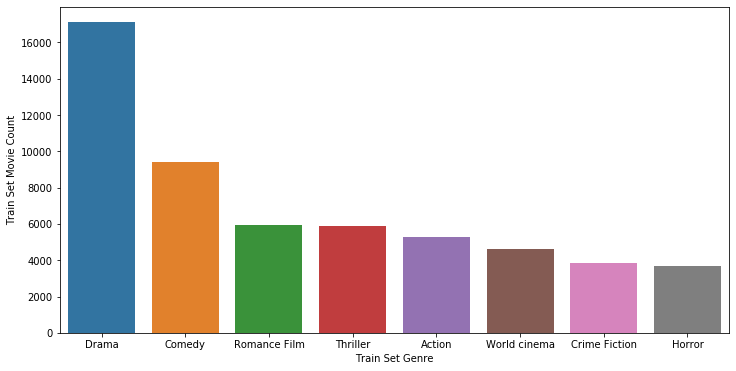

In [19]:
render_genre_freq(Y_train_genre_freq)

# Model

In [20]:
def build_model():
    label_count = Y_genre.shape[1]
    deep_inputs = Input(shape=(SEQUENCE_LEN,))
    embedding_layer = Embedding(VOCAB_WORDLIMIT, 100)(deep_inputs)
    lstm_layer_1 = LSTM(128)(embedding_layer)
    output_layer = Dense(label_count, activation='sigmoid')(lstm_layer_1)
    model = Model(inputs=deep_inputs, outputs=output_layer)
    
    return model

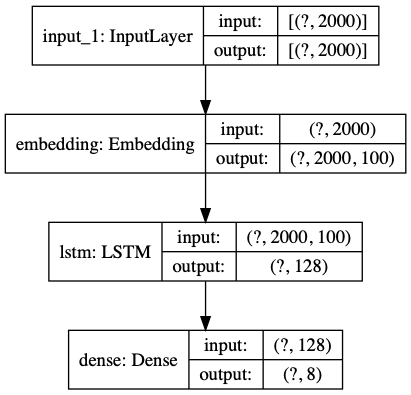

In [21]:
model = build_model()
plot_model(model, 'model.png', show_shapes=True)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2000, 100)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
Total params: 2,118,280
Trainable params: 2,118,280
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [24]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                   validation_data=(X_validate, Y_validate))

Train on 31104 samples, validate on 691 samples
Epoch 1/5
31104/31104 [==============================] - 846s 27ms/sample - loss: 0.5031 - acc: 0.7843 - val_loss: 0.4752 - val_acc: 0.7978
Epoch 2/5
31104/31104 [==============================] - 853s 27ms/sample - loss: 0.4331 - acc: 0.8092 - val_loss: 0.3932 - val_acc: 0.8269
Epoch 3/5
31104/31104 [==============================] - 837s 27ms/sample - loss: 0.3677 - acc: 0.8390 - val_loss: 0.3798 - val_acc: 0.8341
Epoch 4/5
31104/31104 [==============================] - 812s 26ms/sample - loss: 0.3240 - acc: 0.8612 - val_loss: 0.3697 - val_acc: 0.8404
Epoch 5/5
31104/31104 [==============================] - 831s 27ms/sample - loss: 0.2926 - acc: 0.8759 - val_loss: 0.3748 - val_acc: 0.8385


In [25]:
history_dict = history.history
print("history_dict.keys  ->", history_dict.keys())

history_dict.keys  -> dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


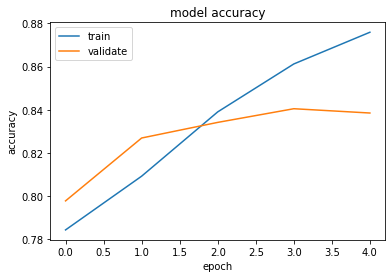

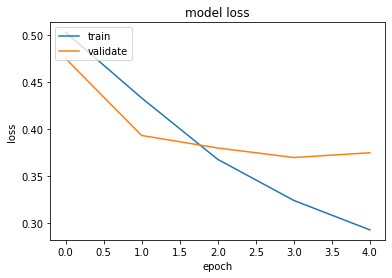

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validate'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validate'], loc='upper left')
plt.show()


## Test data creation

In [27]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
9655,0,0,0,0,0,0,0,0,0,0,...,217,136,658,104,143,856,3938,217,837,143
11137,0,0,0,0,0,0,0,0,0,0,...,21,28,322,4130,1288,316,435,143,90,262
31523,0,0,0,0,0,0,0,0,0,0,...,56,5,50,156,1025,126,189,2503,448,551
14045,0,0,0,0,0,0,0,0,0,0,...,3034,6882,867,1698,518,2164,89,8082,1698,76
96,0,0,0,0,0,0,0,0,0,0,...,524,73,203,4932,7969,113,64,278,14,2687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,0,0,0,0,0,0,0,0,0,0,...,6544,1574,342,2302,80,226,10278,2130,44,1103
4405,0,0,0,0,0,0,0,0,0,0,...,7310,2300,5615,134,487,3186,1269,6052,324,4203
6204,0,0,0,0,0,0,0,0,0,0,...,221,1190,528,16794,41,6477,177,106,1190,3114
21287,0,0,0,0,0,0,0,0,0,0,...,303,116,148,290,1062,398,125,1062,727,45


In [28]:
def create_test_random(X_test, Y_test, slice_size=8):
    XY_test = X_test.join(Y_test)    
    XY_test_random = XY_test.sample(slice_size)
    X_test_random  = XY_test_random.iloc[:,0:SEQUENCE_LEN]
    Y_test_random  = XY_test_random.iloc[:,SEQUENCE_LEN::]
    return(X_test_random , Y_test_random )

In [29]:
X_test_random, Y_test_random = create_test_random(X_test, Y_test)

In [30]:
X_test_random

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
7672,0,0,0,0,0,0,0,0,0,0,...,6,483,9991,477,587,19992,316,5895,5265,7610
5426,0,0,0,0,0,0,0,0,0,0,...,5131,4698,833,508,707,420,73,439,739,2274
23618,0,0,0,0,0,0,0,0,0,0,...,1642,52,71,2819,2,64,7291,8,28,26
3922,0,0,0,0,0,0,0,0,0,0,...,2,54,11066,52,15,2551,3564,421,1689,439
27528,0,0,0,0,0,0,0,0,0,0,...,2137,3474,1491,459,4775,195,30,219,959,515
28232,0,0,0,0,0,0,0,0,0,0,...,522,1318,1113,286,19496,3720,1332,382,874,2279
28979,0,0,0,0,0,0,0,0,0,0,...,2346,582,9496,432,3759,29,56,19,463,292
29445,0,0,0,0,0,0,0,0,0,0,...,292,23,10,888,1123,3032,187,141,2465,71


## Predictions Y_preds

In [31]:
Y_preds = model.predict(X_test_random)
print("Y_preds:", Y_preds.shape, '\n', Y_preds)

Y_preds: (8, 8) 
 [[1.16131697e-02 1.26071498e-01 8.31829458e-02 9.49877739e-01
  7.44742062e-03 2.09598497e-01 8.42001066e-02 1.64407223e-01]
 [8.98869336e-01 6.53000399e-02 5.56942597e-02 3.09748113e-01
  8.80257599e-03 1.01289630e-01 1.53640077e-01 3.55888724e-01]
 [3.62842590e-01 2.66583174e-01 4.06125970e-02 6.13812566e-01
  3.73079302e-03 6.06106043e-01 2.15350837e-02 3.51292938e-01]
 [1.37769785e-02 9.24738288e-01 2.58338614e-03 1.58721119e-01
  8.33927654e-04 3.79977137e-01 1.21261843e-03 3.57334875e-02]
 [1.80823952e-01 4.94497642e-02 4.65841860e-01 2.63504714e-01
  3.21393222e-01 1.82985645e-02 8.52302730e-01 6.22571260e-02]
 [8.56317759e-01 9.86750275e-02 2.90500671e-01 1.90912187e-01
  7.55979866e-03 8.14531185e-03 5.32556593e-01 4.07991484e-02]
 [4.32990462e-01 8.25858295e-01 2.11559534e-02 4.63588089e-02
  1.88826501e-01 1.41992643e-01 4.87008877e-02 1.81521878e-01]
 [5.87094622e-03 4.69461083e-02 1.93260796e-02 9.81144369e-01
  4.31841798e-03 3.25367361e-01 2.91789621e-0

In [32]:
def get_high_predictions(Y_preds, num=4):
    Y_high_preds_idx = np.zeros((Y_preds.shape[0], num), dtype=int)
    print("Y_high_preds_idx.shape:", Y_high_preds_idx.shape)

    for i, pred  in enumerate(Y_preds):
        arr = sorted(pred, reverse=True)[0:num]
        for j, val in enumerate(arr):
            Y_high_preds_idx[i,j] = Y_preds[i].tolist().index(val)
    return Y_high_preds_idx


In [33]:
Y_high_preds_idx = get_high_predictions(Y_preds, num=4)
Y_high_preds_idx

Y_high_preds_idx.shape: (8, 4)


array([[3, 5, 7, 1],
       [0, 7, 3, 6],
       [3, 5, 0, 7],
       [1, 5, 3, 7],
       [6, 2, 4, 3],
       [0, 6, 2, 3],
       [1, 0, 4, 7],
       [3, 5, 7, 1]])

In [34]:
def hot_encode_predictions(Y_high_preds_idx):
    Y_preds_labels = np.zeros(shape =(Y_high_preds_idx.shape[0],
                                      Y_high_preds_idx.shape[1], Y_preds.shape[1]), dtype=int)
    print("Y_preds_labels.shape:", Y_preds_labels.shape)

    for i, indices in enumerate(Y_high_preds_idx):
        for j, idx in enumerate(indices):
            Y_preds_labels[i,j,idx] = 1  
    return Y_preds_labels


In [35]:
Y_preds_labels = hot_encode_predictions(Y_high_preds_idx)
Y_preds_labels

Y_preds_labels.shape: (8, 4, 8)


array([[[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0]],

       [[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]],

       [[0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]],

       [[0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0]],

       [[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]],

       [[0, 0, 0, 1, 0, 0, 0, 0],


###  Genres Y_true

In [36]:
Y_true_labels =[i for i in Y_test_random.to_numpy()]

In [37]:
Y_true_labels

[array([0, 0, 0, 1, 0, 1, 1, 0]),
 array([1, 0, 0, 0, 0, 0, 1, 0]),
 array([1, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 1, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0])]

## Results

In [38]:
for i, labels  in enumerate(Y_preds_labels):
    print("------sample#{}-------".format(i))
    for j, label in enumerate(labels):
        arr = label & Y_true_labels[i]
        if sum(arr)==0:
            print(arr, i, j, " fail")
        else:
            print(arr, i, j, " pass")
    print('\n')


------sample#0-------
[0 0 0 1 0 0 0 0] 0 0  pass
[0 0 0 0 0 1 0 0] 0 1  pass
[0 0 0 0 0 0 0 0] 0 2  fail
[0 0 0 0 0 0 0 0] 0 3  fail


------sample#1-------
[1 0 0 0 0 0 0 0] 1 0  pass
[0 0 0 0 0 0 0 0] 1 1  fail
[0 0 0 0 0 0 0 0] 1 2  fail
[0 0 0 0 0 0 1 0] 1 3  pass


------sample#2-------
[0 0 0 0 0 0 0 0] 2 0  fail
[0 0 0 0 0 0 0 0] 2 1  fail
[1 0 0 0 0 0 0 0] 2 2  pass
[0 0 0 0 0 0 0 0] 2 3  fail


------sample#3-------
[0 1 0 0 0 0 0 0] 3 0  pass
[0 0 0 0 0 0 0 0] 3 1  fail
[0 0 0 0 0 0 0 0] 3 2  fail
[0 0 0 0 0 0 0 0] 3 3  fail


------sample#4-------
[0 0 0 0 0 0 1 0] 4 0  pass
[0 0 0 0 0 0 0 0] 4 1  fail
[0 0 0 0 0 0 0 0] 4 2  fail
[0 0 0 1 0 0 0 0] 4 3  pass


------sample#5-------
[0 0 0 0 0 0 0 0] 5 0  fail
[0 0 0 0 0 0 0 0] 5 1  fail
[0 0 0 0 0 0 0 0] 5 2  fail
[0 0 0 0 0 0 0 0] 5 3  fail


------sample#6-------
[0 1 0 0 0 0 0 0] 6 0  pass
[0 0 0 0 0 0 0 0] 6 1  fail
[0 0 0 0 0 0 0 0] 6 2  fail
[0 0 0 0 0 0 0 0] 6 3  fail


------sample#7-------
[0 0 0 1 0 0 0 0] 7 0  pas

## Graphing Results